In [25]:
import anndata as ad
import numpy as np
import pandas as pd
import os
import scanpy as sc
from scipy.spatial import KDTree
from sklearn.neighbors import BallTree
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Niche Compoistion of Each FOV

In [4]:
# Define the file paths
input_file = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Corrected_CompleteCosMx.h5ad"
output_dir = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NicheCompositions"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "niche_compositions_percent.csv")

def calculate_niche_compositions_percent(input_path, output_path):
    """
    Calculates the percentage composition of NMF_factors for each field of view
    and saves the results to a CSV file.
    """
    try:
        # Load the h5ad file
        adata = ad.read_h5ad(input_path)

        # Check for required columns
        if "NMF_factor" not in adata.obs.columns or "unique_cell_id" not in adata.obs.columns:
            print("Error: The required columns 'NMF_factor' or 'unique_cell_id' were not found.")
            return

        # Extract relevant data into a pandas DataFrame
        df = adata.obs[["unique_cell_id", "NMF_factor"]].copy()

        # Create the 'field_of_view' column using a more robust splitting method.
        # This will split the string at the LAST underscore and take the first part.
        df["field_of_view"] = df["unique_cell_id"].str.rsplit("_", n=1).str[0]

        # Sanity check: Print the number of unique fields of view found.
        num_fields = df["field_of_view"].nunique()
        print(f"Found {num_fields} unique fields of view.")
        
        # Calculate the raw counts of each NMF_factor for each field of view
        niche_counts = pd.pivot_table(
            df,
            index="field_of_view",
            columns="NMF_factor",
            aggfunc="size",
            fill_value=0,
        )

        # Calculate the percentage composition by normalizing the counts for each field of view.
        niche_percent = niche_counts.div(niche_counts.sum(axis=1), axis=0)

        # Save the resulting DataFrame to a CSV file
        niche_percent.to_csv(output_path)
        print(f"Successfully created the percentage composition CSV at: {output_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the function
calculate_niche_compositions_percent(input_file, output_file)

Found 171 unique fields of view.
Successfully created the percentage composition CSV at: /blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NicheCompositions/niche_compositions_percent.csv


In [8]:
# Define the file paths
input_file = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NicheCompositions/niche_compositions_percent.csv"
output_dir = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NicheCompositions"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "niche_compositions_log_transformed.csv")

def transform_and_rename(input_path, output_path):
    """
    Reads the niche composition data, log-transforms the values, renames
    the columns, and saves the result to a new CSV file.
    
    Args:
        input_path (str): The path to the input CSV file.
        output_path (str): The path to the output CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(input_path)
        
        # Check if the "field_of_view" column exists and set it as the index
        if "field_of_view" in df.columns:
            df = df.set_index("field_of_view")
        else:
            print("Error: 'field_of_view' column not found. Cannot proceed.")
            return

        # Identify the columns to transform (all columns except the index)
        columns_to_transform = df.columns
        
        # Check if the columns are numeric (1, 2, 3...)
        if not all(col.isdigit() for col in columns_to_transform):
            print("Warning: The column headers are not all numeric. Attempting to rename based on column order.")
        
        # Create a dictionary for renaming the columns
        rename_dict = {
            col: f"Niche_{col}" for col in columns_to_transform
        }
        
        # Rename the columns
        df.rename(columns=rename_dict, inplace=True)
        
        # Add a small constant to all values to avoid log(0) errors
        # A value of 1e-9 is a common choice for this.
        df_transformed = -np.log(df + 1e-9)

        # Save the log-transformed DataFrame to a new CSV file
        df_transformed.to_csv(output_path)
        print(f"Successfully created the log-transformed CSV at: {output_path}")

    except FileNotFoundError:
        print(f"Error: The file at {input_path} was not found. Please check the path.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Run the function
transform_and_rename(input_file, output_file)

Successfully created the log-transformed CSV at: /blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NicheCompositions/niche_compositions_log_transformed.csv


In [9]:
# Define the file paths
input_file = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NicheCompositions/niche_compositions_log_transformed.csv"
output_dir = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NicheCompositions"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "niche_compositions_final.csv")

def add_disease_state(input_path, output_path):
    """
    Reads a CSV, adds a 'Disease/Health State' column based on the
    'field_of_view', and saves the new CSV.

    Args:
        input_path (str): The path to the input CSV file.
        output_path (str): The path to the output CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(input_path)
        
        # Check if the "field_of_view" column exists
        if "field_of_view" not in df.columns:
            print("Error: 'field_of_view' column not found. Cannot proceed.")
            return

        # Add the 'Disease/Health State' column by splitting the 'field_of_view'
        # and taking the first part.
        df['Disease/Health State'] = df['field_of_view'].apply(lambda x: x.split(' ')[0])

        # Save the updated DataFrame to a new CSV file
        df.to_csv(output_path, index=False)
        print(f"Successfully created the final CSV with the 'Disease/Health State' column at: {output_path}")

    except FileNotFoundError:
        print(f"Error: The file at {input_path} was not found. Please check the path.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Run the function
add_disease_state(input_file, output_file)

Successfully created the final CSV with the 'Disease/Health State' column at: /blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NicheCompositions/niche_compositions_final.csv


## Niche Neighborhood Enrichment Scores per Interaction of Each FOV

In [16]:
# --- 1. Setup and Parameters ---
h5ad_file_path = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/CompleteCosMx_singlecellspatialresolution.h5ad"
output_dir = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions"
os.makedirs(output_dir, exist_ok=True)

# --- Load AnnData ---
print("Loading data...")
adata = sc.read(h5ad_file_path)
print("✅ AnnData loaded.")

# --- Prepare fields ---
adata.obs['Disease_State'] = adata.obs['patient'].astype(str).str[:2]
adata.obs['unique_fov'] = adata.obs['patient'].astype(str) + '_' + adata.obs['fov'].astype(str)

coords_um = adata.obs[['CenterX_global_px', 'CenterY_global_px']].values.astype('float64')
nmf_labels = adata.obs['NMF_factor']
cell_diameters_um = 2 * np.sqrt(adata.obs['Area'] / np.pi)

all_factor_names = sorted(adata.obs['NMF_factor'].unique())

# --- 2. Group by FOV ---
fov_groups = adata.obs.reset_index().groupby('unique_fov')['index'].apply(list)

results = []

for fov_id, cell_indices in tqdm(fov_groups.items(), desc="Processing FOVs"):
    # Subset coordinates, labels, diameters
    original_indices = adata.obs.index.get_indexer(cell_indices)
    fov_coords = coords_um[original_indices]
    fov_cell_diameters = cell_diameters_um.loc[cell_indices].values
    fov_labels = nmf_labels.loc[cell_indices]

    if len(fov_coords) < 2:
        continue

    tree = BallTree(fov_coords)
    interaction_matrix = pd.DataFrame(0, index=all_factor_names, columns=all_factor_names)

    # Count neighbor interactions
    for i in range(len(fov_coords)):
        per_cell_threshold = 2 * fov_cell_diameters[i]
        neighbor_indices = tree.query_radius([fov_coords[i]], r=per_cell_threshold)[0]
        neighbor_indices = neighbor_indices[neighbor_indices != i]

        if len(neighbor_indices) > 0:
            factor_i = fov_labels.iloc[i]
            factors_j = fov_labels.iloc[neighbor_indices]
            counts = factors_j.value_counts()
            for factor, count in counts.items():
                interaction_matrix.loc[factor_i, factor] += count

    # Symmetrize
    interaction_matrix = interaction_matrix + interaction_matrix.T

    # Expected under random mixing
    niche_proportions = fov_labels.value_counts(normalize=True).reindex(all_factor_names, fill_value=0)
    total_interactions = interaction_matrix.sum().sum()
    expected_matrix = total_interactions * np.outer(niche_proportions, niche_proportions)
    expected_matrix = pd.DataFrame(expected_matrix, index=all_factor_names, columns=all_factor_names)

    enrichment = np.log2((interaction_matrix + 1) / (expected_matrix + 1))

    # Flatten results for this FOV
    row = {"field_of_view": fov_id}
    for i, fi in enumerate(all_factor_names, 1):
        for j, fj in enumerate(all_factor_names, 1):
            row[f"enrichment_{i}-{j}"] = enrichment.loc[fi, fj]
    results.append(row)

# --- 3. Save CSV ---
df_out = pd.DataFrame(results)
save_path = os.path.join(output_dir, "FOV_Neighborhood_Enrichment.csv")
df_out.to_csv(save_path, index=False)
print(f"✅ Saved per-FOV enrichment scores to {save_path}")

Loading data...
✅ AnnData loaded.


Processing FOVs: 171it [04:58,  1.74s/it]

✅ Saved per-FOV enrichment scores to /blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions/FOV_Neighborhood_Enrichment.csv


In [17]:
# --- Paths ---
csv_path = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions/FOV_Neighborhood_Enrichment.csv"

# Load CSV
df = pd.read_csv(csv_path)

# Extract Disease/Health State from field_of_view (everything before first underscore)
df["Disease/Health State"] = df["field_of_view"].str.split("_").str[0]

# Save back to CSV (overwrite or new file)
updated_csv_path = csv_path.replace(".csv", "_withDisease.csv")
df.to_csv(updated_csv_path, index=False)

print(f"✅ Updated CSV saved to {updated_csv_path}")

✅ Updated CSV saved to /blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions/FOV_Neighborhood_Enrichment_withDisease.csv


✅ Correlation matrix saved to /blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions/FOV_Neighborhood_Enrichment_withDisease_correlation_matrix.csv


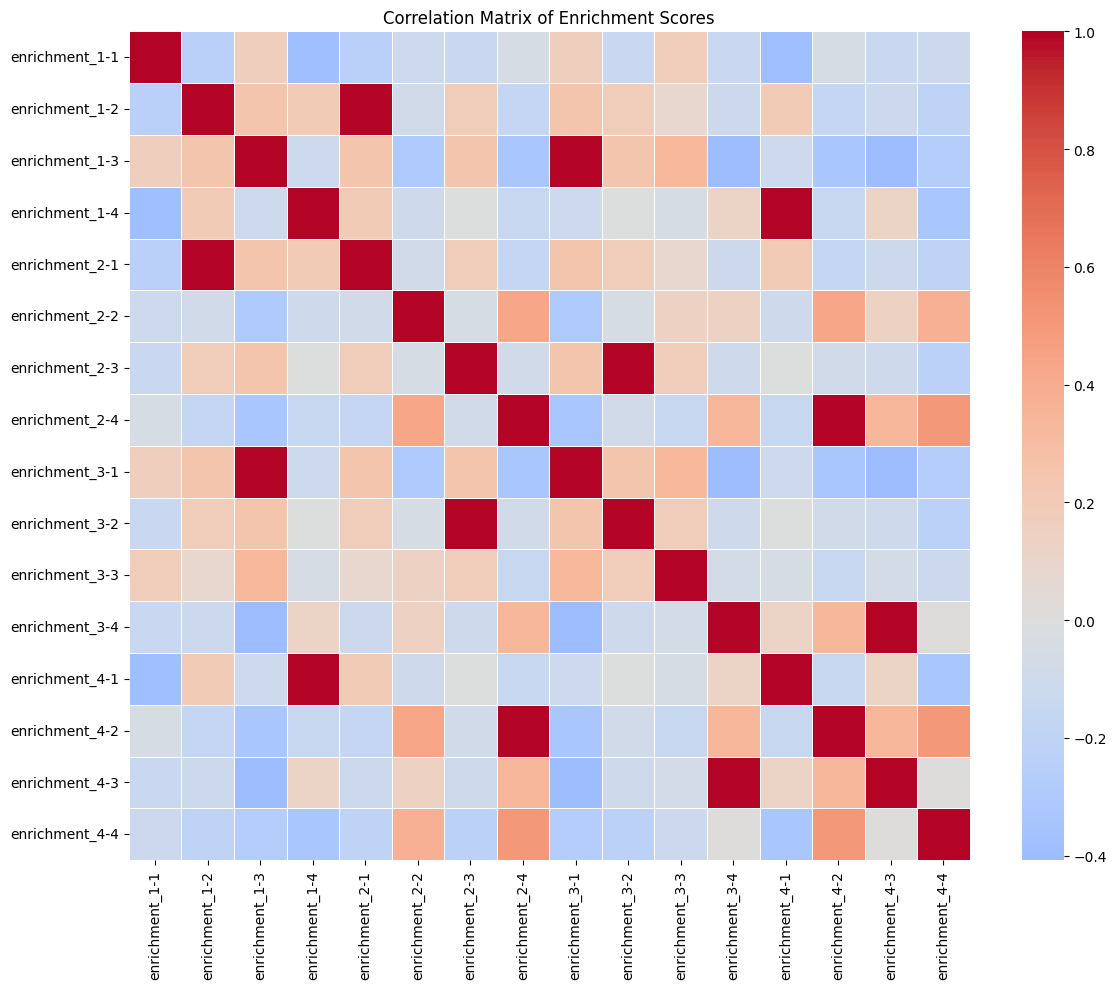

✅ Heatmap saved to /blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions/FOV_Neighborhood_Enrichment_withDisease_correlation_heatmap.png


In [23]:
# --- File path ---
input_file = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions/FOV_Neighborhood_Enrichment_withDisease.csv"

# --- Load data ---
df = pd.read_csv(input_file)

# Keep only enrichment columns (numeric variables)
enrichment_cols = [col for col in df.columns if col.startswith("enrichment_")]
enrichment_data = df[enrichment_cols]

# --- Compute correlation matrix ---
cor_matrix = enrichment_data.corr()

# --- Save correlation matrix to CSV ---
cor_matrix.to_csv(input_file.replace(".csv", "_correlation_matrix.csv"))
print(f"✅ Correlation matrix saved to {input_file.replace('.csv', '_correlation_matrix.csv')}")

# --- Plot heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix of Enrichment Scores")
plt.tight_layout()

# Save heatmap as PNG
heatmap_path = input_file.replace(".csv", "_correlation_heatmap.png")
#plt.savefig(heatmap_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Heatmap saved to {heatmap_path}")

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix of Enrichment Scores")
plt.tight_layout()

# Save at 600 dpi in the same folder
out_path = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions/correlation_matrix.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.close()

print(f"✅ Saved correlation matrix heatmap at {out_path}")

✅ Saved correlation matrix heatmap at /blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions/correlation_matrix.png


In [26]:
# --- File paths ---
input_file = "/blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions/FOV_Neighborhood_Enrichment_withDisease.csv"
output_file = input_file.replace(".csv", "_noCollinear.csv")

# --- Load data ---
df = pd.read_csv(input_file)

# Get all enrichment columns
enrichment_cols = [c for c in df.columns if c.startswith("enrichment_")]

# Track which symmetrical ones to drop
to_drop = set()
seen_pairs = set()

for col in enrichment_cols:
    match = re.match(r"enrichment_(\d+)-(\d+)", col)
    if match:
        a, b = match.groups()
        # create a sorted pair to check symmetry
        pair = tuple(sorted([a, b]))
        if pair in seen_pairs:
            # if we've already seen the reverse, drop this one
            to_drop.add(col)
        else:
            seen_pairs.add(pair)

print(f"Columns to drop (symmetrical ones): {to_drop}")

# Drop only the symmetrical ones
df_reduced = df.drop(columns=list(to_drop))

# Save new CSV
df_reduced.to_csv(output_file, index=False)
print(f"✅ Saved dataset without symmetrical enrichment columns: {output_file}")

Columns to drop (symmetrical ones): {'enrichment_4-2', 'enrichment_3-1', 'enrichment_4-1', 'enrichment_2-1', 'enrichment_3-2', 'enrichment_4-3'}
✅ Saved dataset without symmetrical enrichment columns: /blue/kejun.huang/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/RCausalMGM/NeighborhoodInteractions/FOV_Neighborhood_Enrichment_withDisease_noCollinear.csv
